Ước lượng Lipschitz theo y: 1000
Ước lượng Lipschitz theo y_delay: 999
Độ biến thiên (gradient) delay: 0
(Nếu các giá trị này quá lớn, có thể báo hiệu vi phạm giả định Lipschitz.)

  [Giảm bước] t=0.00000, h=3.565e-04, err=4.064e+03
  [Giảm bước] t=0.00000, h=1.730e-04, err=1.184e-05
  [Giảm bước] t=0.00000, h=1.160e-04, err=3.238e-06
  [Giảm bước] t=0.00000, h=9.394e-05, err=1.528e-06
  [Giảm bước] t=0.00000, h=8.413e-05, err=1.020e-06
  [Giảm bước] t=0.01491, h=2.970e-03, err=2.161e-06
  [Giảm bước] t=0.09869, h=5.941e-04, err=4.290e-04
  [Giảm bước] t=0.09928, h=4.236e-04, err=1.306e-04
  [Giảm bước] t=0.09970, h=4.854e-04, err=6.140e-05
  [Giảm bước] t=0.09970, h=2.264e-04, err=1.386e-05
  [Giảm bước] t=0.09993, h=4.539e-04, err=2.989e-05
  [Giảm bước] t=0.09993, h=2.131e-04, err=1.351e-05
  [Giảm bước] t=0.09993, h=1.375e-04, err=3.778e-06
  [Giảm bước] t=0.09993, h=1.122e-04, err=1.479e-06
  [Giảm bước] t=0.10004, h=9.412e-05, err=1.146e-06
  [Giảm bước] t=0.10112, h=3.074e-04, e

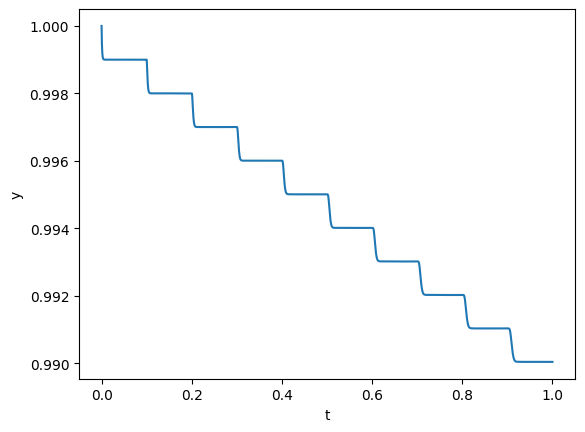

618


In [2]:
import numpy as np

# 1) Hàm kiểm tra gần đúng tính Lipschitz và liên tục của tau
def check_conditions(f, tau, phi, t0, delta=1e-6):
    """
    Kiểm tra gần đúng các điều kiện Lipschitz của f theo y và y_delay,
    và tính liên tục của hàm delay tau.
    Chỉ dùng để cảnh báo sơ bộ.
    """
    y0 = phi(t0)  # Giá trị nghiệm tại t0
    tau0 = tau(t0, y0)
    y_delay0 = phi(t0 - tau0)
    
    f0 = f(t0, y0, y_delay0)
    
    # Sai phân hữu hạn theo y
    f_y = (f(t0, y0 + delta, y_delay0) - f0) / delta
    # Sai phân hữu hạn theo y_delay
    f_yd = (f(t0, y0, y_delay0 + delta) - f0) / delta
    
    L_y = abs(f_y)
    L_yd = abs(f_yd)
    
    # Độ liên tục của tau
    tau_cont = abs(tau(t0 + delta, y0) - tau0) / delta
    
    print("Ước lượng Lipschitz theo y: {:.4g}".format(L_y))
    print("Ước lượng Lipschitz theo y_delay: {:.4g}".format(L_yd))
    print("Độ biến thiên (gradient) delay: {:.4g}".format(tau_cont))
    print("(Nếu các giá trị này quá lớn, có thể báo hiệu vi phạm giả định Lipschitz.)\n")
    
    return L_y, L_yd, tau_cont

# 2) Nội suy Hermite bậc 3 để có nghiệm liên tục
def cubic_hermite(t, t0, t1, y0, y1, f0, f1):
    """
    Nội suy giá trị tại t ∈ [t0, t1] dùng Hermite bậc 3
    (dựa vào giá trị và đạo hàm tại 2 đầu).
    """
    s = (t - t0) / (t1 - t0)
    H00 = 2*s**3 - 3*s**2 + 1
    H10 = -2*s**3 + 3*s**2
    H01 = s**3 - 2*s**2 + s
    H11 = s**3 - s**2
    return (y0 * H00 
            + y1 * H10 
            + (t1 - t0) * (f0 * H01 + f1 * H11))

# 3) Lấy giá trị y(t_eval) bằng lịch sử + nội suy trên các nút đã tính
def get_y_at(t_eval, sol, phi, t0):
    # Nếu t_eval <= t0, dùng hàm lịch sử
    if t_eval <= t0:
        return phi(t_eval)
    # Nếu vượt ngoài phạm vi đã tính, trả về giá trị nút cuối
    if t_eval >= sol[-1]['t']:
        return sol[-1]['y']
    # Tìm đoạn [t_i, t_{i+1}] chứa t_eval
    for i in range(len(sol)-1):
        t_i = sol[i]['t']
        t_ip1 = sol[i+1]['t']
        if t_i <= t_eval <= t_ip1:
            y_i = sol[i]['y']
            y_ip1 = sol[i+1]['y']
            f_i = sol[i]['f']
            f_ip1 = sol[i+1]['f']
            return cubic_hermite(t_eval, t_i, t_ip1, y_i, y_ip1, f_i, f_ip1)
    return None

# 4) Thực hiện một bước RK4/RK3 để ước lượng sai số
def rk_step(t, y, h, sol, f, tau, phi, t0):
    # Tính y_delay cho stage 1
    y_delay = get_y_at(t - tau(t, y), sol, phi, t0)
    k1 = f(t, y, y_delay)
    
    # Stage 2
    t2 = t + h/2
    y2 = y + (h/2)*k1
    y_delay = get_y_at(t2 - tau(t2, y2), sol, phi, t0)
    k2 = f(t2, y2, y_delay)
    
    # Stage 3
    t3 = t + h/2
    y3 = y + (h/2)*k2
    y_delay = get_y_at(t3 - tau(t3, y3), sol, phi, t0)
    k3 = f(t3, y3, y_delay)
    
    # Stage 4
    t4 = t + h
    y4 = y + h*k3
    y_delay = get_y_at(t4 - tau(t4, y4), sol, phi, t0)
    k4 = f(t4, y4, y_delay)
    
    # Nghiệm bậc 4 (RK4)
    y_high = y + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    
    # Nghiệm bậc 3 (embedded)
    # (có nhiều cách xây dựng embedded RK3, ví dụ dùng Heun / classic, minh họa một biến thể đơn giản)
    y_rk3 = y + (h/4)*(k1 + 2*k2 + k3)  # hoặc 1 cách cổ điển
    # Tính sai số
    err = abs(y_high - y_rk3)
    
    return y_high, err, (k1, k2, k3, k4)

# 5) Thuật toán giải DDE bằng CRK (RK4 + Hermite) với bước tự điều chỉnh
def solve_dde_adaptive(f, tau, phi, t0, t_final, 
                       tol=1e-5, h_init=0.1, h_min=1e-8, h_max=0.5):
    """
    f, tau, phi như mô tả:
       - f(t, y, y_delay)
       - tau(t, y)
       - phi(t): lịch sử
    t0: thời điểm bắt đầu (ở đây t0=1)
    t_final: thời điểm kết thúc
    tol: ngưỡng sai số
    h_init, h_min, h_max: bước khởi tạo, nhỏ nhất, lớn nhất.
    Trả về: sol (list các dict {'t':, 'y':, 'f':})
    """
    sol = []
    # Giá trị ban đầu
    y0 = phi(t0)
    y_delay0 = phi(t0 - tau(t0, y0))  # vì t0=1 => t0 - tau(1,y0) = 1 - (log(1)+1)=0 => phi(0)=1
    f0 = f(t0, y0, y_delay0)
    sol.append({'t': t0, 'y': y0, 'f': f0})
    
    t = t0
    y = y0
    h = h_init
    
    while t < t_final:
        # Điều chỉnh để không vượt quá t_final
        if t + h > t_final:
            h = t_final - t
        
        # Tính một bước
        y_high, err, k_stages = rk_step(t, y, h, sol, f, tau, phi, t0)
        
        # Nếu sai số < tol, chấp nhận bước
        if err <= tol:
            t_new = t + h
            y_new = y_high
            # Tính f tại nút mới
            y_delay_new = get_y_at(t_new - tau(t_new, y_new), sol, phi, t0)
            f_new = f(t_new, y_new, y_delay_new)
            sol.append({'t': t_new, 'y': y_new, 'f': f_new})
            
            t = t_new
            y = y_new
            
            # Điều chỉnh bước cho lần tiếp theo (theo quy tắc tỉ lệ 1/4)
            # Hệ số an toàn 0.9
            factor = 0.9 * (tol / (err + 1e-14))**0.25
            h = min(h * factor, h_max)
        else:
            # Sai số quá lớn => giảm bước
            factor = 0.9 * (tol / (err + 1e-14))**0.25
            h = max(h * factor, h_min)
            # In cảnh báo nếu muốn
            print(f"  [Giảm bước] t={t:.5f}, h={h:.3e}, err={err:.3e}")
            
        # Nếu h quá nhỏ mà vẫn không thoả mãn, có thể dừng/báo lỗi.
        if h < 1e-14:
            print("Bước quá nhỏ, có thể bài toán không thỏa mãn giả định Lipschitz hoặc sai số quá chặt.")
            break
    
    return sol

def f_example(t, y, y_delay):
    return -1000*y+999*y_delay

def tau_example(t, y):
    return 0.1

def phi_example(t):
    return 1.0

t0 = 0
t_final = 1

# 6) Kiểm tra nhanh các điều kiện Lipschitz
check_conditions(f_example, tau_example, phi_example, t0)

# 7) Giải DDE
sol_example = solve_dde_adaptive(
    f=f_example,
    tau=tau_example,
    phi=phi_example,
    t0=t0,
    t_final=t_final,
    tol=1e-6,      # sai số có thể giảm xuống 1e-7, 1e-8 nếu cần
    h_init=0.1,    # bước khởi tạo
    h_min=1e-10,   # bước nhỏ nhất
    h_max=0.5      # bước lớn nhất
)

# 8) In (hoặc vẽ) kết quả
print("\n--- KẾT QUẢ TÍNH ---")
for node in sol_example:
    print(f"t = {node['t']:.5f}, y = {node['y']:.8f}")
#Vẽ đồ thị
import matplotlib.pyplot as plt
t_values = [node['t'] for node in sol_example]
y_values = [node['y'] for node in sol_example]
plt.plot(t_values, y_values)
plt.xlabel('t')
plt.ylabel('y')
plt.show()
print(len(t_values))


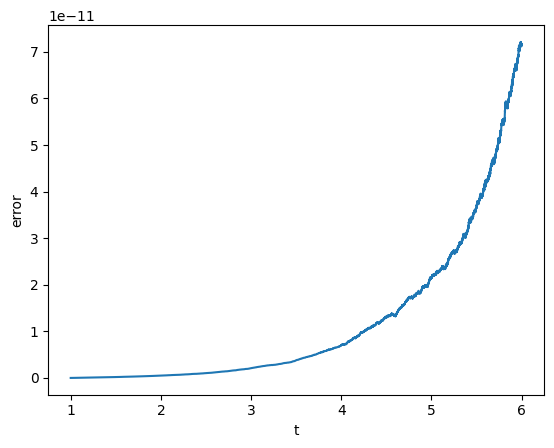

7.213429853436537e-11


In [3]:
#tính sai số
y_exact = [np.exp(t) for t in t_values]
error = np.abs(np.array(y_values) - np.array(y_exact))
#vẽ đồ thị sai số
plt.plot(t_values, error)
plt.xlabel('t')
plt.ylabel('error')
# plt.yscale('log')
plt.show()
print(max(error))

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ---- 1) Hệ số CERK4 (6 stages) ----
c = np.array([0,
              1/6,
              11/37,
              11/17,
              13/15,
              1], dtype=float)

a = np.zeros((6,6))
a[1,0] = 1/6
a[2,0], a[2,1] =  44/1369,   363/1369
a[3,0], a[3,1], a[3,2] =  3388/4913,  -8349/4913,  8140/4913
a[4,0], a[4,1], a[4,2], a[4,3] = -36764/408375, 767/1125, -32708/136125, 210392/408375
a[5,0], a[5,1], a[5,2], a[5,3], a[5,4] = 1697/18876, 0, 50653/116160, 299693/1626240, 3375/11648

# continuous‐extension weights b_i(θ):
def b1(θ): return (-866577/824252)*θ**4 + (1806901/618189)*θ**3 - (104217/37466)*θ**2 + θ
def b2(θ): return 0.0
def b3(θ): return (12308679/5072320)*θ**4 - (2178079/380424)*θ**3 + (861101/230560)*θ**2
def b4(θ): return -(7816583/10144640)*θ**4 + (6244423/5325936)*θ**3 - (638869/293440)*θ**2
def b5(θ): return -(624375/217984)*θ**4 + (982125/190736)*θ**3 - (1522125/762944)*θ**2
def b6(θ): return (296/131)*θ**4 - (461/131)*θ**3 + (165/131)*θ**2

b_funcs = [b1, b2, b3, b4, b5, b6]
b_disc  = np.array([bf(1.0) for bf in b_funcs], dtype=float)


# ---- 2) Một bước CERK ----
def cerk_step(f, history, t, y, h, tau):
    K = []
    for i in range(6):
        ti = t + c[i]*h
        yi = y.copy()
        if i > 0:
            incr = np.zeros_like(y)
            for j in range(i):
                incr += a[i,j] * K[j]
            yi = yi + h*incr

        y_delay = history(ti - tau)
        Ki = f(ti, yi, y_delay)        # Ki cũng là vector độ dài d
        K.append(Ki)

    y_next = y + h * sum(b_disc[i]*K[i] for i in range(6))
    return y_next, K


# ---- 3) Solver chính với adaptive step (step‐doubling) ----
def solve_dde_cerk4(f, phi, t0, t_end, tau,
                    h0=0.1, tol=1e-6, max_steps=100000):
    # segments lưu (t_n, y_n, h_n, K_n) để nội suy y(t-τ)
    segments = []

    def history(s):
        if s <= t0:
            return np.atleast_1d(phi(s))
        # tìm segment chứa s
        for t_n, y_n, h_n, K_n in segments:
            if t_n <= s <= t_n + h_n:
                θ = (s - t_n)/h_n
                val = y_n + h_n * sum(b_funcs[i](θ)*K_n[i] for i in range(6))
                return val
        # nếu vượt segment cuối
        return segments[-1][1]

    t = t0
    y = np.atleast_1d(phi(t0))
    ts, ys = [t], [y.copy()]
    h = min(h0, tau)
    step = 0

    while t < t_end and step < max_steps:
        if t + h > t_end: h = t_end - t

        # full step
        y_full, K_full = cerk_step(f, history, t, y, h, tau)
        # two half-steps
        y_h1, K_h1 = cerk_step(f, history, t, y, h/2, tau)

        # tạm thêm segment nửa đầu để nội suy trong nửa sau
        seg_half = (t, y, h/2, K_h1)
        def hist2(s):
            if s <= t0: return np.atleast_1d(phi(s))
            if t <= s <= t + h/2:
                θ = (s-t)/(h/2)
                return y + (h/2)*sum(b_funcs[i](θ)*K_h1[i] for i in range(6))
            return history(s)

        y_h2, _ = cerk_step(f, hist2, t + h/2, y_h1, h/2, tau)
        # ước lượng error
        err = np.max(np.abs(y_h2 - y_full))
        if err < tol:
            # accept
            segments.append((t, y.copy(), h, K_full))
            t += h; y = y_h2.copy()
            ts.append(t); ys.append(y.copy())
            fac = np.clip((tol/err)**(1/5), 0.2, 5.0)
            h = min(h*fac, tau, t_end - t)
        else:
            fac = np.clip((tol/err)**(1/5), 0.1, 0.8)
            h *= fac

        step += 1

    return np.array(ts), np.vstack(ys)


# ---- 4) Ví dụ hệ 2 chiều ----
if __name__ == "__main__":

    α, β, τ = 2.0, 1.5, 0.1

    def phi(t):
        return np.array([1.0])

    def f(t, y, y_delay):
        y = np.atleast_1d(y)
        y_delay = np.atleast_1d(y_delay)
        return -1000*y+999*y_delay

    ts, ys = solve_dde_cerk4(f, phi, t0=0.0, t_end=0.5,
                             tau=τ, h0=0.1, tol=1e-5)

    plt.plot(ts, ys)
    # plt.plot(ts, ys[:,1], label="y2(t)")
    plt.legend(); plt.xlabel("t"); plt.show()


KeyboardInterrupt: 

In [20]:
import itertools
from math import prod

# Define the rooted tree structure
class Tree:
    def __init__(self, children):
        self.children = tuple(children)
    
    def order(self):
        # number of nodes in subtree
        return 1 + sum(child.order() for child in self.children)
    
    def canonical(self):
        # unique repr by sorted children reprs
        child_reprs = sorted(child.canonical() for child in self.children)
        return "(" + "".join(child_reprs) + ")"
    
    def __repr__(self):
        return self.canonical()

# Generate integer partitions for tree construction
def integer_partitions(n, max_val=None):
    if n == 0:
        return [[]]
    if max_val is None or max_val > n:
        max_val = n
    parts = []
    for k in range(max_val, 0, -1):
        for rest in integer_partitions(n - k, k):
            parts.append([k] + rest)
    return parts

# Generate all non-isomorphic rooted trees up to order p
def generate_trees(p):
    T = {1: [Tree([])]}
    for n in range(2, p+1):
        unique = {}
        for part in integer_partitions(n-1):
            for combo in itertools.product(*(T[k] for k in part)):
                t = Tree(combo)
                unique[t.canonical()] = t
        T[n] = list(unique.values())
    return T

# Classical continuous-extension gamma: product of sizes of all subtrees
def gamma(tree):
    if not tree.children:
        return 1
    return tree.order() * prod(gamma(child) for child in tree.children)

# Generate phi_i(t) for continuous RK:
varnames = ['j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r']

def phi_cont(tree, parent='i', idx=0):
    """Return (expr_str, next_idx, indices_list) for phi_i(t)."""
    if not tree.children:
        # leaf: c_i
        return f"c_{parent}", idx, []
    expr_parts = []
    indices = []
    for child in tree.children:
        if not child.children:
            # leaf child: factor c_parent
            expr_parts.append(f"c_{parent}")
        else:
            # non-leaf: add a sum over new index var
            var = varnames[idx]
            idx += 1
            subexpr, idx, subinds = phi_cont(child, parent=var, idx=idx)
            expr_parts.append(f"Σ_{{{var}}} a_{{{parent}{var}}}*({subexpr})")
            indices.append(var)
            indices.extend(subinds)
    return " * ".join(expr_parts), idx, indices

# Print continuous extension conditions up to order p
def print_dense_conditions(p):
    trees = generate_trees(p)
    for k in range(1, p+1):
        print(f"--- Order {k} ---")
        for t in trees[k]:
            expr, _, inds = phi_cont(t)
            gamma_t = gamma(t)
            # build sum indices string
            all_inds = ['i'] + inds
            sum_sub = ",".join(all_inds)
            print(f"Σ_{{{sum_sub}}} b_i(θ) * {expr} = 1/{gamma_t} θ^{k}")
        print()

# Example usage
if __name__ == "__main__":
    print_dense_conditions(6)


--- Order 1 ---
Σ_{i} b_i(θ) * c_i = 1/1 θ^1

--- Order 2 ---
Σ_{i} b_i(θ) * c_i = 1/2 θ^2

--- Order 3 ---
Σ_{i,j} b_i(θ) * Σ_{j} a_{ij}*(c_j) = 1/6 θ^3
Σ_{i} b_i(θ) * c_i * c_i = 1/3 θ^3

--- Order 4 ---
Σ_{i,j,k} b_i(θ) * Σ_{j} a_{ij}*(Σ_{k} a_{jk}*(c_k)) = 1/24 θ^4
Σ_{i,j} b_i(θ) * Σ_{j} a_{ij}*(c_j * c_j) = 1/12 θ^4
Σ_{i,j} b_i(θ) * Σ_{j} a_{ij}*(c_j) * c_i = 1/8 θ^4
Σ_{i} b_i(θ) * c_i * c_i * c_i = 1/4 θ^4

--- Order 5 ---
Σ_{i,j,k,l} b_i(θ) * Σ_{j} a_{ij}*(Σ_{k} a_{jk}*(Σ_{l} a_{kl}*(c_l))) = 1/120 θ^5
Σ_{i,j,k} b_i(θ) * Σ_{j} a_{ij}*(Σ_{k} a_{jk}*(c_k * c_k)) = 1/60 θ^5
Σ_{i,j,k} b_i(θ) * Σ_{j} a_{ij}*(Σ_{k} a_{jk}*(c_k) * c_j) = 1/40 θ^5
Σ_{i,j} b_i(θ) * Σ_{j} a_{ij}*(c_j * c_j * c_j) = 1/20 θ^5
Σ_{i,j,k} b_i(θ) * Σ_{j} a_{ij}*(Σ_{k} a_{jk}*(c_k)) * c_i = 1/30 θ^5
Σ_{i,j} b_i(θ) * Σ_{j} a_{ij}*(c_j * c_j) * c_i = 1/15 θ^5
Σ_{i,j,k} b_i(θ) * Σ_{j} a_{ij}*(c_j) * Σ_{k} a_{ik}*(c_k) = 1/20 θ^5
Σ_{i,j} b_i(θ) * Σ_{j} a_{ij}*(c_j) * c_i * c_i = 1/10 θ^5
Σ_{i} b_i(θ) * c_i * c_i * c